In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

#Import BZ mixing code
from calc_mixing_production_bz import keel, find_mask, pad, find_zstar, rho_deriv, calc_mixing

In [2]:
#%% Constants / set-up
z0 = 8 # Depth of mixed layer [m]
rho1 = 1022.49 # Density of mixed layer (used as reference density rho0)
rho2 = 1024.12 # Density of deeper ocean
mu = 2e-3 # Salt-mass diffusivity [m^2/s]
g = 9.8 # Acceleration due to gravity [m/s^2]
L = 960 # Domain length [m]
H = 80 # Domain height [m]
h = 2*z0 # Keel height (for F20H20) [m]
l = 75*z0 # Keel center location [m]
Nx = 1280 # Number of grid points in horizontal
Nz = 640 # Number of grid points in vertical
x = np.linspace(0, L, Nx) # Horizontal grid points [m]
z = np.linspace(0, H, Nz) # Vertical grid points (increasing downwards) [m]

sigma = 3.9 * h # Keel characteristic width
dx = L/Nx # Grid spacing in x
dz = H/Nz # Grid spacing in z
vol = dx*dz # "Volume" (area) of each grid cell

zv, xv = np.meshgrid(z,x) # create meshgrid of (x,z) coordinates

Nx_mid = int(np.where(np.abs(x-l) == np.min(np.abs(x-l)))[0])

In [3]:
# Import density field
rho = json.load(open('F20H20_rho_220.txt')) # F20H20 (vortex shedding regime) at snapshot t=220t_0 (1280x640 2D array)
rho = np.array(rho)[:, ::-1] # Reorder so rho[0][0] is top left of domain

Here, we will calculate mixing both upstream and downstream of the keel. I also provided estimates for area-integrated values of mixing downstream and upstream in units $kg\, m/s^3 = W/m$. We do get more mixing downstream of the keel.

In [4]:
#Calculate upstream
b_up, zs_up, mixing_up = calc_mixing(rho,h,l,Nx,Nz,zv,0,Nx_mid,dz,vol,1,x,z)
rho_deriv_up = rho_deriv(rho,x,z)[:Nx_mid,:]

#Calculate downstream
b_down, zs_down, mixing_down = calc_mixing(rho,h,l,Nx,Nz,zv,Nx_mid,Nx-1,dz,vol,0,x,z)
rho_deriv_down = rho_deriv(rho,x,z)[Nx_mid:Nx-1,:]

#%% "Volume" (area) integrated mixing for each domain
keel_mask = find_mask(h, l, Nx, Nz, zv) #mask out the keel
mixing_up_ma = np.ma.array(mixing_up,mask=keel_mask[:Nx_mid,:])
mixing_dn_ma = np.ma.array(mixing_down,mask=keel_mask[Nx_mid:Nx-1,:])

tot_mix_up = np.sum(mixing_up_ma)*vol*g*mu #tot mixing upstream
tot_mix_dn = np.sum(mixing_dn_ma)*vol*g*mu #tot mixing downstream

In [6]:
print("Mixing upstream: {0:.1f} W/m; \n  Mixing downstream: {1:.1f} W/m ".format(tot_mix_up, tot_mix_dn))

Mixing upstream: 118.6 W/m; 
  Mixing downstream: 225.3 W/m 


Below, I plot both the computed mixing and density gradients ($(\nabla \rho)^2$) both upstream and downstream of the keel. The structure of mixing closely follows that of the density gradients.

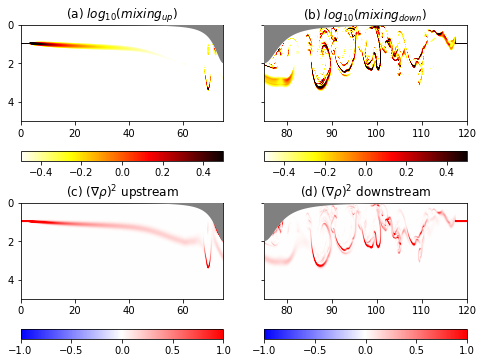

In [7]:
#Plot mixing and density gradients ((\del \rho)^2) both upstream and downstream 
fig, axs = plt.subplots(2, 2, sharey=True)
ax1 = axs[0,0]
c = ax1.imshow(np.transpose(np.log10(mixing_up)), vmin=-0.5, vmax=0.5,
                   cmap='hot_r', 
                   extent=(0, l/z0, H/z0, 0))
ax1.set_xlim(0, l/z0)
ax1.set_ylim(H/(2*z0), 0)
ax1.set_aspect('auto')
ax1.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax1, orientation='horizontal', pad=0.2)
ax1.set_title('(a) $log_{10}(mixing_{up})$')

ax2 = axs[0,1]
c = ax2.imshow(np.transpose(np.log10(mixing_down)), vmin=-0.5, vmax=0.5,
                   cmap='hot_r', 
                   extent=(l/z0, L/z0, H/z0, 0))
ax2.set_xlim(l/z0, L/z0)
ax2.set_ylim(H/(2*z0), 0)
ax2.set_aspect('auto')
ax2.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax2, orientation='horizontal', pad=0.2)
ax2.set_title('(b) $log_{10}(mixing_{down})$');

ax3 = axs[1,0]
c = ax3.imshow(np.transpose(rho_deriv_up), vmin=-1, vmax=1,
                   cmap='bwr', 
                   extent=(0, l/z0, H/z0, 0))
ax3.set_xlim(0, l/z0)
ax3.set_ylim(H/(2*z0), 0)
ax3.set_aspect('auto')
ax3.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax3, orientation='horizontal', pad=0.2)
ax3.set_title('(c) $(\\nabla \\rho)^2$ upstream');

ax4 = axs[1,1]
c = ax4.imshow(np.transpose(rho_deriv_down), vmin=-1, vmax=1,
                   cmap='bwr', 
                   extent=(l/z0, L/z0, H/z0, 0))
ax4.set_xlim(l/z0, L/z0)
ax4.set_ylim(H/(2*z0), 0)
ax4.set_aspect('auto')
ax4.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax4, orientation='horizontal', pad=0.2)
ax4.set_title('(d) $(\\nabla \\rho)^2$ downstream');
fig.set_size_inches(8, 6)

Importantly, here is what is different from Sam's code and where he went wrong. $z^*(\rho)$ is a one-to-one function, i.e., $z^*$ only depends on $\rho$ or $\rho^*$ only depends on $z$. Then, $dz^*/d\rho$ only depends on $\rho$ or equivalently, $d\rho^*/dz$ only depends on $z$. That is because we want to find the **minimum potential energy state**, which because the gravity is only pointed downwards (vertically) in our coordinate system, everything has to be aligned horizontally-uniformly and vertically stacked from lightest fluid at the top to densest fluid at the bottom. Below are plots of $\rho^*(z)$ computed within the downstream and upstream of the keel regions.

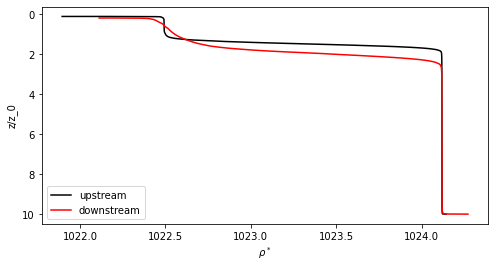

In [8]:
fig, ax = plt.subplots(figsize=(8,4)) 
ax.plot(b_up, zs_up/z0,'k',label = 'upstream')
ax.plot(b_down,zs_down/z0,'r',label='downstream')
plt.gca().invert_yaxis()
ax.set_xlabel('$\\rho^*$')
ax.set_ylabel('z/z_0')
ax.legend(loc='lower left')

Here's instead what Sam did in his code. I am showing example only for the downstream case just for illustrative purposes. In Sam's code, the resorting is done on all the fluid parcels within the domain based on density (this part is correct, modulo the keel not being excluded). But then, it just reshapes that 1D sorted vector into 2D (x,z) space, which creates density distribution both on x and z, i.e., Sam's $\rho^*$ is a function of both (x,z). See figure below. That is not minimum potential energy state because we have gradients in $x$ that have some available potential energy - the denser particles on the right want to sink to reach the minimum potential energy state. In Sam's code, then the vertical derivative is taken at each $x$, i.e., $\partial \rho^*/\partial z$ is again a function of both (x,z). **It doesn't appear to be that big of a difference because there is a strong halocline in this set-up and things are strongly horizontally uniform, but you can imagine that there will be situations where this kind of resorting would yield unexpected and incorrect horizontal gradients.**

In [9]:
import math
def generate_modes(L_1, L_2, H_1, H_2):
    # Generates the grid point index for horziontal and vertical gird spacing Nx and Nz
    Nf_x = math.ceil(Nx/L*L_2)
    Ni_x = math.floor(Nx/L*L_1)
    Ni_z = math.ceil((1-H_2/H)*Nz)
    Nf_z = math.floor((1-H_1/H)*Nz)
    return Nf_x, Ni_x, Nf_z, Ni_z

def sort_rho_z(rho, L_1, L_2, H_1, H_2):
    # Returns the sorted densitiy field (rho_ref[0][0] is the bottom left corner of the domain)
    Nf_x, Ni_x, Nf_z, Ni_z = generate_modes(L_1, L_2, H_1, H_2)
    rho = rho[Ni_x:Nf_x, Ni_z:Nf_z]	  # Restrict rho to selected domain
    rho_sort = np.reshape(-np.sort(-rho.flatten()), (Nf_x-Ni_x, Nf_z-Ni_z), order='F') 
    return rho_sort

rho_ref = sort_rho_z(rho,  l, L, 0, H)
rho = rho[:, ::-1] # Flip second axis of rho so rho[0][0] is top left corner of the domain 
rho_ref = rho_ref[:, ::-1]
drdz = np.gradient(rho_ref, z, axis=1, edge_order=2)

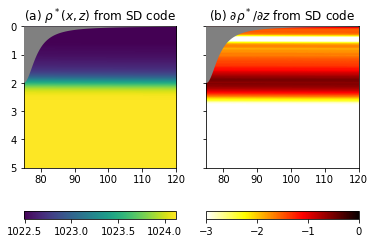

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True)
ax1 = axs[0]
c = ax1.imshow(np.transpose(rho_ref), vmin=rho1, vmax=rho2,
                   cmap='viridis', 
                   extent=( l/z0,L/z0, H/z0, 0))
ax1.set_xlim(l/z0,L/z0,)
ax1.set_ylim(H/(2*z0), 0)
ax1.set_aspect('auto')
ax1.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax1, orientation='horizontal', pad=0.2)
ax1.set_title('(a) $\\rho^*(x,z)$ from SD code');

ax2 = axs[1]
c = ax2.imshow(np.transpose(np.log10(drdz)), 
                   cmap='hot_r', vmin=-3, vmax=0,
                   extent=(l/z0,L/z0, H/z0, 0))
ax2.set_xlim(l/z0,L/z0,)
ax2.set_ylim(H/(2*z0), 0)
ax2.set_aspect('auto')
ax2.fill_between(x/z0, 0, keel(h, l, x)/z0, facecolor="gray", zorder=10)
cbar = fig.colorbar(c, ax=ax2, orientation='horizontal', pad=0.2)
ax2.set_title('(b) $\partial \\rho^*/\partial z$ from SD code');

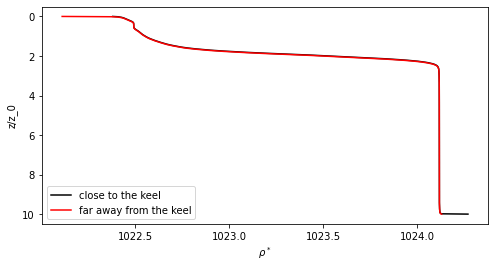

In [12]:
fig, ax = plt.subplots(figsize=(8,4)) 
ax.plot(rho_ref[0,:], z/z0,'k',label = 'close to the keel')
ax.plot(rho_ref[-1,:],z/z0,'r',label='far away from the keel')
plt.gca().invert_yaxis()
ax.set_xlabel('$\\rho^*$')
ax.set_ylabel('z/z_0')
ax.legend(loc='lower left')